In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [155]:
#gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')
#ml_stats = Table.read('ml_stats_matched.fits')
#galaxy_level_data = Table.read('galaxy_level_data.fits')
#ml_table = Table.read('ml_table_matched.fits')
#mendel_data = Table.read('../fits/Simard+Mendel/mendel_matched.fits')

In [164]:
from combining_catalogues import make_matched_catalogue, match_ids

ids_ = match_ids(gz2_data,galaxy_level_data,'dr8objid','id')
galaxy_level_matched = make_matched_catalogue(gz2_data,galaxy_level_data,ids_)
galaxy_level_matched.write('galaxy_level_matched.fits',overwrite=True)

248883 galaxies in the reference catalogue
5442 galaxies in the match catalogue
---> 5442 matches in total


In [145]:
# Get ID columns in the right format:
mendel_data['dr7id'] = gz2_data['dr7objid']
mendel_data['dr8id'] = gz2_data['dr8objid']
mendel_data['logMbd'] = np.log10(10**mendel_data['logMb'] + 10**mendel_data['logMd'])
mendel_data['BTR'] = 10**(mendel_data['logMb'] - mendel_data['logMbd'])
mendel_data['logBTR'] = np.log10(mendel_data['BTR'])
mendel_data.write('../fits/Simard+Mendel/mendel_matched.fits',
                     overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


In [48]:
# create a table of relevant mendel data?
has_bulge = mendel_data['logMb'] > 0
has_disc = mendel_data['logMd'] > 0
F_test = mendel_data['PpS']

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [353]:
in_ml = ml_stats['redshift_error_ok'] == 1
print('{} galaxies in the ML sample!'.format(in_ml.sum()))
F_test_ok = F_test <= 0.5
unbarred = ml_stats['p_bar'] < 0.5
ml_F_sample = np.all([in_ml,F_test_ok,unbarred],axis=0)
print('{} have bulge+disc!'.format(ml_F_sample.sum()))
in_sparcfire_r = galaxy_level_matched['has_good_arc'] == 1
ml_F_sparcfire = np.all([ml_F_sample,in_sparcfire_r],axis=0)
print('{} have sparcfire arcs!'.format(ml_F_sparcfire.sum()))

7062 galaxies in the ML sample!
4008 have bulge+disc!
1830 have sparcfire arcs!


In [405]:
import xy_plots
import imp
imp.reload(xy_plots)
from xy_plots import x_vs_y

def bulge_disc_plotter(mass_table,y,weights=None,figaxarr=None,label=True,
                       error_kwargs={'alpha':0.2},
                       line_kwargs={'linewidth':2},spearmanr=None):
    if figaxarr is None:
        fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharey=True)
        fig.subplots_adjust(hspace=0,wspace=0)
    else:
        fig, axarr = figaxarr
        
    xs = [mass_table[c] for c in ['logMb','logMd','logMbd','BTR']]
    figlabels = 'abcd'
    for ax, x, figlabel in zip(axarr,xs,figlabels):
        ax.text(0.05,0.95,'({})'.format(figlabel),
                transform=ax.transAxes,ha='left',va='top')
        xy = x_vs_y(x,y,weights)
        xy.continuous_vs_continuous_binned(equal_N=True,bins=8)
        xy.line_plot(ax,**line_kwargs)
        xy.error_plot(ax,**error_kwargs)
        if spearmanr is not None:
            xy.spearmanr(ax,location=spearmanr,fontsize=15)
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0,hspace=0)
    
    return fig, axarr

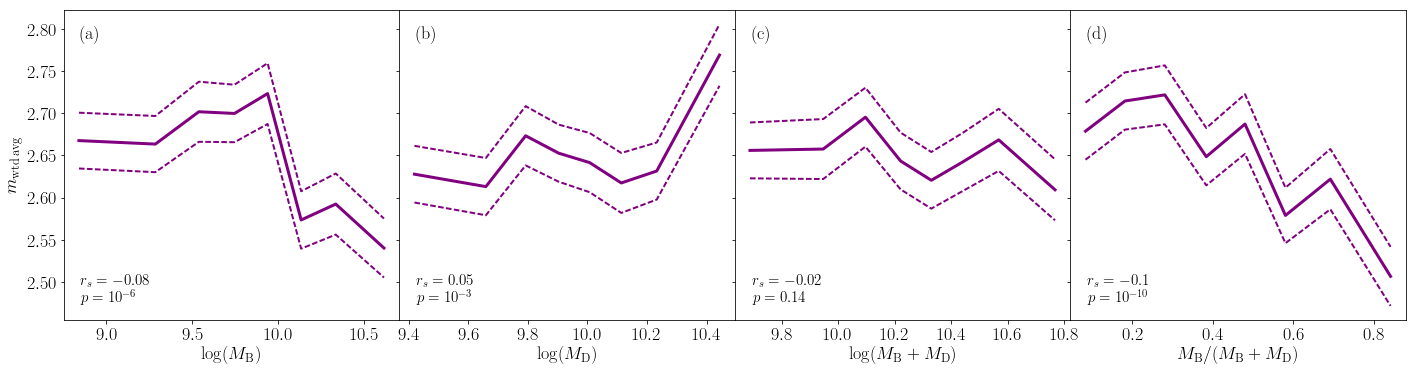

In [410]:
import warnings
warnings.filterwarnings('ignore')

x_ = mendel_data[ml_F_sample]
y_ = ml_stats['m_wtd_avg'][ml_F_sample]
w_ = ml_stats['vmax_weight'][ml_F_sample]

fig, axarr = bulge_disc_plotter(x_,y_,w_,
                                error_kwargs={'style':'lined','color':'purple',
                                              'linewidth':2,'linestyle':'dashed'},
                                line_kwargs={'linewidth':3,'color':'purple'},
                                spearmanr='lower left')

xlabels = ('$\log(M_\mathrm{B})$','$\log(M_\mathrm{D})$',
           '$\log(M_\mathrm{B}+M_\mathrm{D})$',
           '$M_\mathrm{B}/(M_\mathrm{B}+M_\mathrm{D})$')

for ax, xlabel in zip(axarr,xlabels):
    ax.set_xlabel(xlabel)
    
_ = axarr[0].set_ylabel('$m_\mathrm{wtd \, avg}$')

fig.savefig('paper_figures/bd_vs_m.pdf')

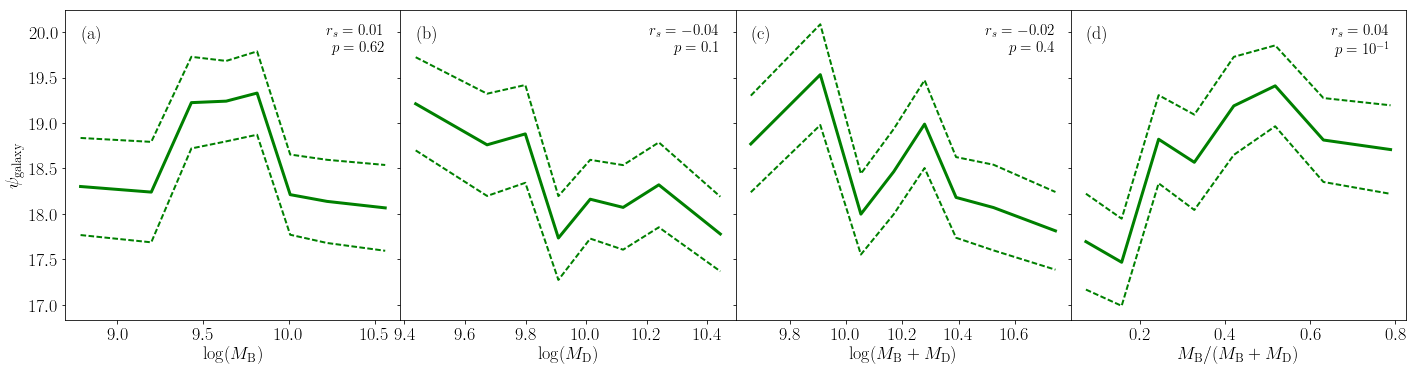

In [411]:
x_ = mendel_data[ml_F_sparcfire]
y_ = galaxy_level_matched['P_wtd_avg'][ml_F_sparcfire]
w_ = ml_stats['vmax_weight'][ml_F_sparcfire]


fig, axarr = bulge_disc_plotter(x_,y_,w_,
                                error_kwargs={'style':'lined','color':'g',
                                              'linewidth':2,'linestyle':'dashed'},
                                line_kwargs={'linewidth':3,'color':'g'},
                                spearmanr='upper right')

#m_2 = ml_stats['m'] == 2
#ml_F_sparcfire_2 = np.all([ml_F_sparcfire,m_2],axis=0)
#x_ = mendel_data[ml_F_sparcfire_2]
#y_ = galaxy_level_matched['P_wtd_avg'][ml_F_sparcfire_2]
#w_ = ml_stats['vmax_weight'][ml_F_sparcfire_2]

xlabels = ('$\log(M_\mathrm{B})$','$\log(M_\mathrm{D})$',
           '$\log(M_\mathrm{B}+M_\mathrm{D})$',
           '$M_\mathrm{B}/(M_\mathrm{B}+M_\mathrm{D})$')

for ax, xlabel in zip(axarr,xlabels):
    ax.set_xlabel(xlabel)
    
_ = axarr[0].set_ylabel('$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
fig.savefig('paper_figures/bd_vs_P.pdf')

#### Final plot for now: SFR vs. spiral ar number + spiral arm pitch angle

In [413]:
sfrs = Table.read('../fits/SF_fits/sfrs+ids.fits')

In [446]:
def sfr_plotter(sfr_table,y,figaxarr=None,
                error_kwargs={'alpha':0.2},
                line_kwargs={'linewidth':2},spearmanr=None):
    
    if figaxarr is None:
        fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharey=True)
        fig.subplots_adjust(hspace=0,wspace=0)
    else:
        fig, axarr = figaxarr
    
    ok_F = sfr_table['F'] >= 2
    ok_w4 = sfr_table['w4'] >= 2
    ok_mpa = sfr_table['sfr_mpa'] >= -3
    masks = [ok_F,ok_w4,np.all([ok_F,ok_w4],axis=0),ok_mpa]
    columns = ['sfr_fuv','sfr_22','sfr_total','sfr_mpa']
    figlabels = 'abcd'
    
    for ax, mask, column, figlabel in zip(axarr,masks,columns,figlabels):
        _ = ax.text(0.05,0.95,'({}) $N_\mathrm{{gal}}={}$'.format(figlabel,mask.sum()),
                    transform=ax.transAxes,ha='left',va='top')
        x_ = sfr_table[column][mask]
        y_ = y[mask]
        xy = x_vs_y(x_,y_)
        xy = xy.continuous_vs_continuous_binned(equal_N=True,bins=8)
        xy.line_plot(ax,**line_kwargs)
        xy.error_plot(ax,**error_kwargs)
        if spearmanr is not None:
            xy.spearmanr(ax,location=spearmanr,fontsize=15)
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0,hspace=0)
    
    return fig, axarr

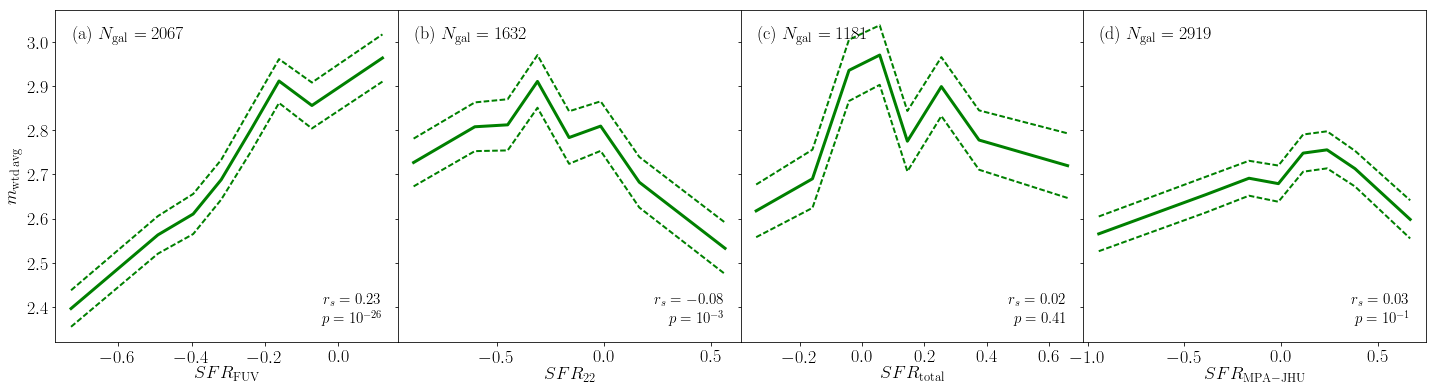

In [454]:
in_mm = np.all([ml_stats['redshift_error_ok'] == 1,
                ml_stats['mass_matched_2'],ml_stats['p_bar'] < 0.5],
                axis=0)

x_ = sfrs[in_mm]
y_ = ml_stats['m_wtd_avg'][in_mm]

fig, axarr = sfr_plotter(x_,y_,spearmanr='lower right',
                         error_kwargs={'style':'lined','color':'g',
                                       'linewidth':2,'linestyle':'dashed'},
                         line_kwargs={'linewidth':3,'color':'g'})

xlabels = ('$SFR_\mathrm{FUV}$','$SFR_\mathrm{22}$',
           '$SFR_\mathrm{total}$','$SFR_\mathrm{MPA-JHU}$')

for ax, xlabel in zip(axarr,xlabels):
    _ = ax.set_xlabel(xlabel)
    
_ = axarr[0].set_ylabel('$m_\mathrm{wtd \, avg}$')

fig.savefig('paper_figures/sfr_vs_m.pdf')

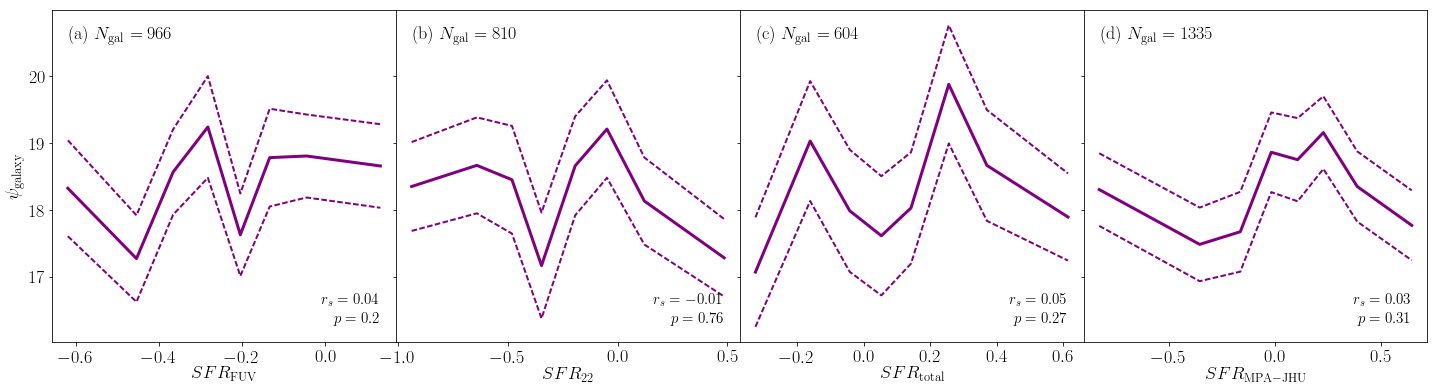

In [456]:
in_mm_sparcfire = np.all([in_mm,in_sparcfire_r],
                         axis=0)

x_ = sfrs[in_mm_sparcfire]
y_ = galaxy_level_matched['P_wtd_avg'][in_mm_sparcfire]

fig, axarr = sfr_plotter(x_,y_,spearmanr='lower right',
                         error_kwargs={'style':'lined','color':'purple',
                                       'linewidth':2,'linestyle':'dashed'},
                         line_kwargs={'linewidth':3,'color':'purple'})

xlabels = ('$SFR_\mathrm{FUV}$','$SFR_\mathrm{22}$',
           '$SFR_\mathrm{total}$','$SFR_\mathrm{MPA-JHU}$')

for ax, xlabel in zip(axarr,xlabels):
    _ = ax.set_xlabel(xlabel)
    
_ = axarr[0].set_ylabel('$\psi_\mathrm{galaxy}$')

fig.savefig('paper_figures/sfr_vs_P.pdf')